# Financial Analysis in Python

What you will learn in this tutorial
------------------------------------

* Timeseries analysis using Pandas
* Using Google Trends to predict market movements
* Build your own trading strategy using Zipline
* Common trading strategies:
   * Momentum trading
   * Mean-reversion

Different stages towards a successful trading strategy
------------------------------------------------------

1. Data analysis / Idea generation
   * Pandas + Matplotlib (Part I)
2. Backtest strategy
   * Pandas can be used but many limitations (Part II)
   * -> Zipline (Part III)
3. Optimize
   * See my previous [PyData talk](http://blog.quantopian.com/zipline_in_the_cloud/)
4. Forward test strategy (paper trading)
   * Trivial on Quantopian (Part IV)
5. Live trading!
   * Coming soon...

# Pandas basics (Data analysis / Idea generation)

In [1]:
from IPython.core.display import HTML
HTML("<iframe src=http://pandas.pydata.org width=800 height=350></iframe>")

In [55]:
import datetime
import numpy as np

import pandas as pd
#import pandas.io.data
from pandas_datareader import data, wb
from pandas import Series, DataFrame
pd.__version__

u'0.17.1'

In [37]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rc('figure', figsize=(8, 7))
mpl.__version__


'1.4.3'

Creating/loading time series data
===================

* From Python structures
* From Yahoo finance
* From CSV files

### From Python structures

In [6]:
labels = ['a', 'b', 'c', 'd', 'e']
s = Series([1, 2, 3, 4, 5], index=labels)
s

a    1
b    2
c    3
d    4
e    5
dtype: int64

In [7]:
'b' in s

True

In [8]:
s['b']

2

In [9]:
mapping = s.to_dict()
mapping

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5}

In [10]:
Series(mapping)

a    1
b    2
c    3
d    4
e    5
dtype: int64

### From Yahoo finance

In [13]:
aapl = data.get_data_yahoo('AAPL', 
                           start=datetime.datetime(2006, 10, 1), 
                           end=datetime.datetime(2012, 1, 1))
aapl.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2006-10-02,75.100003,75.870001,74.299998,74.859998,178159800,9.957604
2006-10-03,74.450002,74.950000,73.190000,74.080000,197677200,9.853852
2006-10-04,74.100000,75.459998,73.159999,75.380003,207270700,10.026773
2006-10-05,74.529997,76.160001,74.130001,74.829997,170970800,9.953614
2006-10-06,74.420001,75.040002,73.810000,74.220003,116739700,9.872474


### From CSV files

In [17]:
aapl.to_csv('data/aapl_ohlc.csv')
!head data/aapl_ohlc.csv

Date,Open,High,Low,Close,Volume,Adj Close
2006-10-02,75.100003,75.870001,74.299998,74.859998,178159800,9.957604
2006-10-03,74.450002,74.95,73.19,74.08,197677200,9.853852
2006-10-04,74.1,75.459998,73.159999,75.380003,207270700,10.026773
2006-10-05,74.529997,76.160001,74.130001,74.829997,170970800,9.953614
2006-10-06,74.420001,75.040002,73.81,74.220003,116739700,9.872474
2006-10-09,73.8,75.080003,73.530001,74.629999,109555600,9.927011
2006-10-10,74.539997,74.579998,73.079997,73.81,132897100,9.817937
2006-10-11,73.419998,73.979998,72.599999,73.23,142963800,9.740788
2006-10-12,73.610003,75.390003,73.600002,75.26,148213800,10.010811


In [18]:
df = pd.read_csv('data/aapl_ohlc.csv', index_col='Date', parse_dates=True)
df.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2006-10-02,75.100003,75.870001,74.299998,74.859998,178159800,9.957604
2006-10-03,74.450002,74.950000,73.190000,74.080000,197677200,9.853852
2006-10-04,74.100000,75.459998,73.159999,75.380003,207270700,10.026773
2006-10-05,74.529997,76.160001,74.130001,74.829997,170970800,9.953614
2006-10-06,74.420001,75.040002,73.810000,74.220003,116739700,9.872474


In [19]:
df.index

DatetimeIndex(['2006-10-02', '2006-10-03', '2006-10-04', '2006-10-05',
               '2006-10-06', '2006-10-09', '2006-10-10', '2006-10-11',
               '2006-10-12', '2006-10-13',
               ...
               '2011-12-16', '2011-12-19', '2011-12-20', '2011-12-21',
               '2011-12-22', '2011-12-23', '2011-12-27', '2011-12-28',
               '2011-12-29', '2011-12-30'],
              dtype='datetime64[ns]', name=u'Date', length=1323, freq=None)

Series and DataFrame: First steps
=================================

* Indexing
* Slicing
* Creating new columns

In [20]:
ts = df['Close'][-10:]
ts

Date
2011-12-16    381.019989
2011-12-19    382.210003
2011-12-20    395.949997
2011-12-21    396.450008
2011-12-22    398.550003
2011-12-23    403.330006
2011-12-27    406.529999
2011-12-28    402.640003
2011-12-29    405.120007
2011-12-30    405.000004
Name: Close, dtype: float64

A DataFrame is a collection of Series objects. Slicing out a DataFrame column returns a Series.

In [32]:
type(ts)

pandas.core.series.Series

In [22]:
date = ts.index[5]
date

Timestamp('2011-12-23 00:00:00')

In [23]:
ts[date]

403.33000600000003

In [24]:
ts[5]

403.33000600000003

We can also select multiple columns.

In [25]:
df[['Open', 'Close']].head()

,Open,Close
Date,,
2006-10-02,75.100003,74.859998
2006-10-03,74.450002,74.080000
2006-10-04,74.100000,75.380003
2006-10-05,74.529997,74.829997
2006-10-06,74.420001,74.220003


New columns can be added on the fly.

In [26]:
df['diff'] = df.Open - df.Close
df.head()

,Open,High,Low,Close,Volume,Adj Close,diff
Date,,,,,,,
2006-10-02,75.100003,75.870001,74.299998,74.859998,178159800,9.957604,0.240005
2006-10-03,74.450002,74.950000,73.190000,74.080000,197677200,9.853852,0.370002
2006-10-04,74.100000,75.459998,73.159999,75.380003,207270700,10.026773,-1.280003
2006-10-05,74.529997,76.160001,74.130001,74.829997,170970800,9.953614,-0.300000
2006-10-06,74.420001,75.040002,73.810000,74.220003,116739700,9.872474,0.199998


...and deleted on the fly.

In [27]:
del df['diff']
df.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2006-10-02,75.100003,75.870001,74.299998,74.859998,178159800,9.957604
2006-10-03,74.450002,74.950000,73.190000,74.080000,197677200,9.853852
2006-10-04,74.100000,75.459998,73.159999,75.380003,207270700,10.026773
2006-10-05,74.529997,76.160001,74.130001,74.829997,170970800,9.953614
2006-10-06,74.420001,75.040002,73.810000,74.220003,116739700,9.872474


Common Financial Computations
-----------------------------

* Moving Average
* Returns

In [30]:
close_px = df['Adj Close']

In [31]:
pd.rolling_mean?

In [29]:
mavg = pd.rolling_mean(close_px, 40)
mavg[-10:]

Date
2011-12-16    51.704489
2011-12-19    51.669040
2011-12-20    51.636384
2011-12-21    51.631995
2011-12-22    51.625178
2011-12-23    51.620655
2011-12-27    51.625909
2011-12-28    51.618793
2011-12-29    51.647425
2011-12-30    51.672665
Name: Adj Close, dtype: float64

Returns defined as: 
$$ $$
$$r_t = \frac{p_t - p_{t-1}}{p_{t-1}} = \frac{p_t}{p_{t-1}} - 1$$

In [33]:
rets = close_px / close_px.shift(1) - 1
rets.head()

Date
2006-10-02         NaN
2006-10-03   -0.010419
2006-10-04    0.017549
2006-10-05   -0.007296
2006-10-06   -0.008152
Name: Adj Close, dtype: float64

Or alternatively `.pct_change()`.

In [34]:
close_px.pct_change().head()

Date
2006-10-02         NaN
2006-10-03   -0.010419
2006-10-04    0.017549
2006-10-05   -0.007296
2006-10-06   -0.008152
Name: Adj Close, dtype: float64

Plotting Basics
---------------

Series and DataFrames have an associated `.plot()` command (uses Matplotlib behind the scenes).

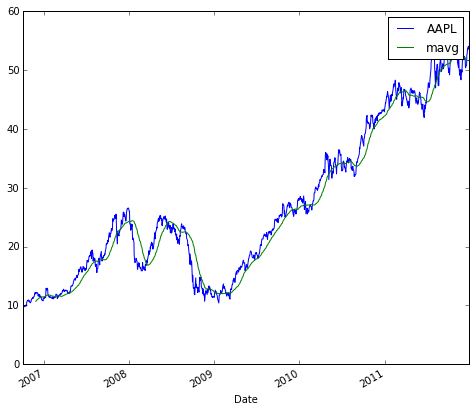

In [38]:
close_px.plot(label='AAPL')
mavg.plot(label='mavg')
plt.legend()

## Optional: If there is time...

In [40]:
df = data.get_data_yahoo(['AAPL', 'GE', 'GOOGL', 'IBM', 'KO', 'MSFT', 'PEP'], 
                          start=datetime.datetime(2010, 1, 1), 
                          end=datetime.datetime(2013, 1, 1))['Adj Close']
df.head()

,AAPL,GE,GOOGL,IBM,KO,MSFT,PEP
Date,,,,,,,
2010-01-04,28.466830,12.657489,313.688694,116.564610,23.874306,26.415914,51.317187
2010-01-05,28.516046,12.723029,312.307316,115.156514,23.585503,26.424448,51.937282
2010-01-06,28.062460,12.657489,304.434422,114.408453,23.577133,26.262284,51.417742
2010-01-07,28.010584,13.312893,297.347355,114.012427,23.518534,25.989163,51.090935
2010-01-08,28.196808,13.599632,301.311314,115.156514,23.083239,26.168398,50.923341


In [41]:
rets = df.pct_change()

C:\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


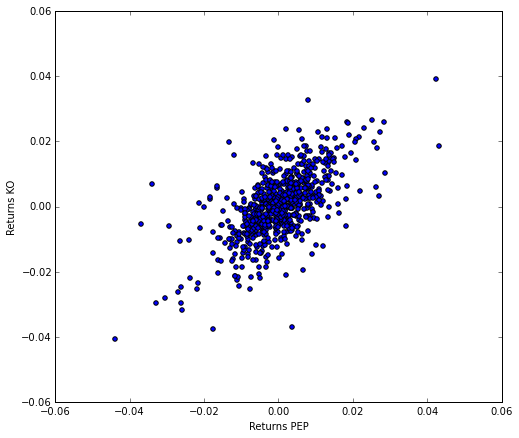

In [42]:
plt.scatter(rets.PEP, rets.KO)
plt.xlabel('Returns PEP')
plt.ylabel('Returns KO')

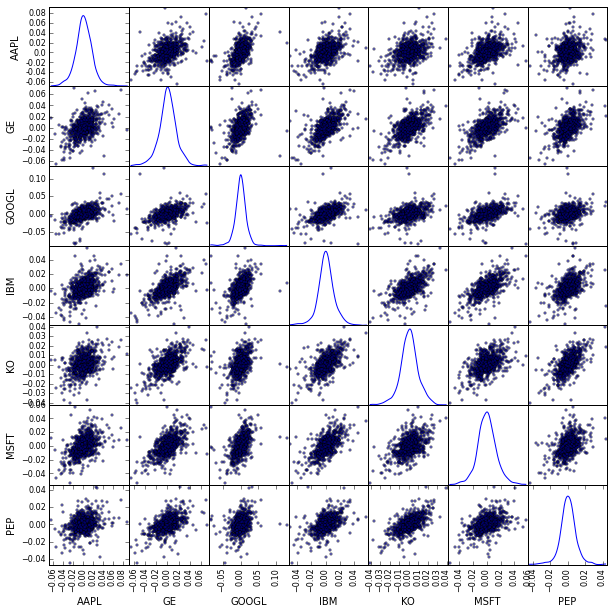

In [43]:
pd.scatter_matrix(rets, diagonal='kde', figsize=(10, 10));

In [44]:
corr = rets.corr()
corr

,AAPL,GE,GOOGL,IBM,KO,MSFT,PEP
AAPL,1.000000,0.457052,0.533387,0.501587,0.388007,0.472767,0.308964
GE,0.457052,1.000000,0.462696,0.609330,0.593856,0.600065,0.533503
GOOGL,0.533387,0.462696,1.000000,0.470778,0.404099,0.472851,0.329938
IBM,0.501587,0.609330,0.470778,1.000000,0.601483,0.646124,0.491088
KO,0.388007,0.593856,0.404099,0.601483,1.000000,0.523479,0.635843
MSFT,0.472767,0.600065,0.472851,0.646124,0.523479,1.000000,0.477424
PEP,0.308964,0.533503,0.329938,0.491088,0.635843,0.477424,1.000000


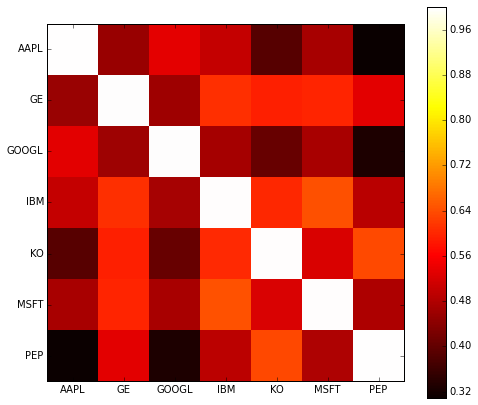

In [45]:
plt.imshow(corr, cmap='hot', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns);

One thing we are often interested in is the relationship of expected returns and the risk we are taking one. Often there is a trade-off between the two.

Here we use `plt.annotate` to put labels on the scatterplot.

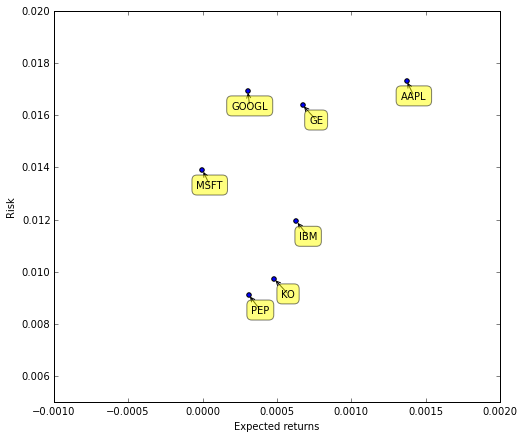

In [48]:
plt.scatter(rets.mean(), rets.std())
plt.xlabel('Expected returns')
plt.ylabel('Risk')
plt.xlim([-.001,.002])
plt.ylim([.005,.020])
for label, x, y in zip(rets.columns, rets.mean(), rets.std()):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (20, -20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

Data alignment and dealing with missing values
==============

* Join, merge, concatenate
* Filling NaNs

Lets pull some more securities from Yahoo finance and build a DataFrame of the adjusted closing prices.

In [51]:
series_list = []
securities = ['AAPL', 'GOOGL', 'IBM', 'MSFT']
for security in securities:
    s = data.get_data_yahoo(security, start=datetime.datetime(2011, 10, 1), end=datetime.datetime(2013, 1, 1))['Adj Close']
    s.name = security # Rename series to match security name
    series_list.append(s)

`pd.concat` can be used to concatenate multiple `Series` into one `DataFrame`.

In [52]:
df = pd.concat(series_list, axis=1)
df.head()

,AAPL,GOOGL,IBM,MSFT
Date,,,,
2011-10-03,49.827927,248.008014,157.420069,21.776300
2011-10-04,49.548594,251.201206,158.737289,22.495370
2011-10-05,50.313436,252.602603,160.654056,22.983627
2011-10-06,50.196382,257.612613,165.050804,23.383111
2011-10-07,49.189448,257.817813,165.686695,23.303215


In [57]:
df.ix[0, 'AAPL'] = np.nan
df.ix[1, ['GOOGL', 'IBM']] = np.nan
df.ix[[1, 2, 3], 'MSFT'] = np.nan

df.head()

,AAPL,GOOGL,IBM,MSFT
Date,,,,
2011-10-03,NaN,248.008014,157.420069,21.776300
2011-10-04,49.548594,NaN,NaN,NaN
2011-10-05,50.313436,252.602603,160.654056,NaN
2011-10-06,50.196382,257.612613,165.050804,NaN
2011-10-07,49.189448,257.817813,165.686695,23.303215


Pandas has great support for computing with missing values.

In [58]:
(df.AAPL + df.GOOGL).head()

Date
2011-10-03           NaN
2011-10-04           NaN
2011-10-05    302.916039
2011-10-06    307.808995
2011-10-07    307.007261
dtype: float64

One common approach to impute missing values in time series is forward filling.

In [59]:
df.ffill().head()

,AAPL,GOOGL,IBM,MSFT
Date,,,,
2011-10-03,NaN,248.008014,157.420069,21.776300
2011-10-04,49.548594,248.008014,157.420069,21.776300
2011-10-05,50.313436,252.602603,160.654056,21.776300
2011-10-06,50.196382,257.612613,165.050804,21.776300
2011-10-07,49.189448,257.817813,165.686695,23.303215
